# Packages

In [1]:
import warnings
import pandas as pd
import numpy as np
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
from glob import glob

sns.color_palette("mako", as_cmap=True)
warnings.filterwarnings('ignore')
np.random.seed(42)


# Data Prep

Dataset: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data <br/>
H&M Group is a family of brands and businesses with 53 online markets and approximately 4,850 stores. 

In this project we only used 2 tabular data:
1. transactions_train.csv (**txs_df**)
1. articles.csv (**product_df**) <br/>

Also feature selection is performed on both of tabular data to only filter features that importance for later interaction modeling.

In [2]:
txs_df = pd.read_csv('data/transactions_train.csv', parse_dates=['t_dat'])
product_df = pd.read_csv('data/articles.csv')

In [3]:
print("Transactions table cols: \n", txs_df.columns)
txs_df

Transactions table cols: 
 Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2
...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,891322004,0.042356,2
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,918325001,0.043203,1
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.006763,1


In [3]:
print("Product table cols:\n", product_df.columns)

print("filtered product_df cols:")
product_df = product_df[['article_id', 'prod_name', 'product_group_name', 'colour_group_name', 'index_group_name', 'graphical_appearance_name']]
product_df

Product table cols:
 Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')
filtered product_df cols:


,article_id,prod_name,product_group_name,colour_group_name,index_group_name,graphical_appearance_name
0,108775015,Strap top,Garment Upper body,Black,Ladieswear,Solid
1,108775044,Strap top,Garment Upper body,White,Ladieswear,Solid
2,108775051,Strap top (1),Garment Upper body,Off White,Ladieswear,Stripe
3,110065001,OP T-shirt (Idro),Underwear,Black,Ladieswear,Solid
4,110065002,OP T-shirt (Idro),Underwear,White,Ladieswear,Solid
...,...,...,...,...,...,...
105537,953450001,5pk regular Placement1,Socks & Tights,Black,Menswear,Placement print
105538,953763001,SPORT Malaga tank,Garment Upper body,Black,Ladieswear,Solid
105539,956217002,Cartwheel dress,Garment Full body,Black,Ladieswear,Solid
105540,957375001,CLAIRE HAIR CLAW,Accessories,Black,Divided,Solid


# Feature Engineering

Collect recent 4 months of data:
- Training: 3 months 
- Simulation/Testing: 1 months 

In [4]:
start_test = txs_df['t_dat'].max() - pd.Timedelta(days=30)
start_train = start_test - pd.Timedelta(days=90)

txs_train = txs_df[(txs_df['t_dat'] >= start_train) & (txs_df['t_dat'] < start_test)].copy()
txs_test = txs_df[txs_df['t_dat'] >= start_test].copy()

del txs_df
print(f"Train set from {txs_train['t_dat'].min()} to {txs_train['t_dat'].max()}, total {len(txs_train)} txs")
print(f"Test set from {txs_test['t_dat'].min()} to {txs_test['t_dat'].max()}, total {len(txs_test)} txs")

Train set from 2020-05-25 00:00:00 to 2020-08-22 00:00:00, total 4378949 txs
Test set from 2020-08-23 00:00:00 to 2020-09-22 00:00:00, total 1155933 txs


## Create bundles data

Since the actual raw data does not contain any bundle informations, here we create our own bundles by assuming:
- Products that bought at the same time by the same user likely are related and can be bundled.

In [5]:
train_bundles = txs_train.groupby(['customer_id', 't_dat']).agg({
    'article_id': lambda x: list(x),
    'price': lambda x: list(x)
}).reset_index()
train_bundles = train_bundles[train_bundles['article_id'].map(len) > 1]

test_bundles = txs_test.groupby(['customer_id', 't_dat']).agg({
    'article_id': lambda x: list(x),
    'price': lambda x: list(x)
}).reset_index()
test_bundles = test_bundles[test_bundles['article_id'].map(len) > 1]

Generate ground truth (label = 1) for each pair of products in the bundles as the positive pairs. <br/>
Also create the negative pair of products data (label = 0) to tell which items that rarely bought together by random selection.

In [6]:
def generate_pos_neg_pairs(bundle_df, txs_df):
    # Lookup table for negative sample prices
    price_map = txs_df.groupby('article_id')['price'].mean()

    # Generate positive pairs data
    pos_data = []
    for ids, prices in zip(bundle_df['article_id'], bundle_df['price']):
        
        # Combine ID and Price into tuples: [(id1, p1), (id2, p2), ...]
        zipped_items = list(zip(ids, prices))
        zipped_items.sort(key=lambda x: x[0])
        
        # Generate combinations
        for (item_a, price_a), (item_b, price_b) in combinations(zipped_items, 2):
            pos_data.append([item_a, item_b, price_a, price_b, 1])

    feat_pos_df = pd.DataFrame(pos_data, columns=['item_a', 'item_b', 'price_a', 'price_b', 'label'])
    feat_pos_df.drop_duplicates(inplace=True)

    # Generate negative pairs data
    num_negatives = len(feat_pos_df)
    valid_articles = price_map.index.values 
    neg_items_a = np.random.choice(valid_articles, num_negatives)
    neg_items_b = np.random.choice(valid_articles, num_negatives)
    neg_prices_a = price_map.loc[neg_items_a].values
    neg_prices_b = price_map.loc[neg_items_b].values

    feat_neg_df = pd.DataFrame({
        'item_a': neg_items_a,
        'item_b': neg_items_b,
        'price_a': neg_prices_a,
        'price_b': neg_prices_b,
        'label': 0
    })

    # Final data cleanup
    feat_df = pd.concat([feat_pos_df, feat_neg_df], ignore_index=True)
    feat_df = feat_df[feat_df['item_a'] != feat_df['item_b']]
    feat_df.drop_duplicates(subset=['item_a', 'item_b'], keep='first', inplace=True)
    feat_df = feat_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return feat_df

In [7]:
train_df = generate_pos_neg_pairs(train_bundles, txs_train)
test_df = generate_pos_neg_pairs(test_bundles, txs_test)

del train_bundles
del test_bundles
train_df.head(10)

,item_a,item_b,price_a,price_b,label
0,870442005,805510027,0.024913,0.015758,0
1,769263004,777430002,0.013542,0.010153,0
2,748354001,816498002,0.058363,0.014729,0
3,865566001,872079001,0.018047,0.015177,0
4,891025004,561372001,0.049343,0.010153,0
5,700817001,866457001,0.016940,0.064778,0
6,622314010,840360002,0.009136,0.007610,1
7,893444003,807922003,0.025000,0.031763,0
8,523490003,937915002,0.001678,0.022017,1
9,704756001,832309010,0.033881,0.050831,1


## Interaction modeling

Here model the interaction for the generated positive and negative pairs based on the product detail information. We created new feature based on the similarity of each filtered product's attribute and create a new vectors (length of 4) which each value is actually binary representation of this interactions:

- **is_same_appearance** (Stripe, Solid, etc)
- **is_same_color** (White, Beige, etc)
- **is_same_target** (Manswear, Ladieswear, Kids)
- **is_cross_category** (Garment, Accessories, etc)
- **price_diff** (price_item_a - price_item_b)
- **price_ratio** (price_item_a / price_item_b)

In [8]:
def merge_product_features(df, prod_df, suffix):
    temp = df.merge(prod_df, 
                    left_on=f'item_{suffix}', 
                    right_on='article_id', 
                    how='left')
    
    cols_to_rename = {col: f"{col}_{suffix}" for col in temp.columns if col not in df.columns}
    temp = temp.rename(columns=cols_to_rename)
    temp = temp.drop(columns=['article_id_' + suffix])
    
    return temp


def create_item_interaction_feat(feat_df):
    res = feat_df[['item_a', 'item_b', 'label']].copy()

    # product detail features interactions
    res['is_same_appearance'] = (feat_df['graphical_appearance_name_a'] == feat_df['graphical_appearance_name_b']).astype(int)
    res['is_same_color'] = (feat_df['colour_group_name_a'] == feat_df['colour_group_name_b']).astype(int)
    res['is_same_target'] = (feat_df['index_group_name_a'] == feat_df['index_group_name_b']).astype(int)
    is_same_category = (feat_df['product_group_name_a'] == feat_df['product_group_name_b']).astype(int)
    res['is_cross_category'] = 1 - is_same_category

    # product price interaction
    res['price_diff'] = np.abs(feat_df['price_a'] - feat_df['price_b'])
    res['price_ratio'] = feat_df['price_a'] / (feat_df['price_b'] + 1e-5)

    return res


In [9]:
train_df = merge_product_features(train_df, product_df, 'a')
train_df = merge_product_features(train_df, product_df, 'b')
test_df = merge_product_features(test_df, product_df, 'a')
test_df = merge_product_features(test_df, product_df, 'b')

train_df.head(10)

,item_a,item_b,price_a,price_b,label,prod_name_a,product_group_name_a,colour_group_name_a,index_group_name_a,graphical_appearance_name_a,prod_name_b,product_group_name_b,colour_group_name_b,index_group_name_b,graphical_appearance_name_b
0,870442005,805510027,0.024913,0.015758,0,Elly Fancy,Garment Upper body,Black,Divided,Embroidery,AMY TSHIRT,Garment Upper body,Dark Blue,Ladieswear,Stripe
1,769263004,777430002,0.013542,0.010153,0,TOM tank 2-p,Garment Upper body,Other Yellow,Baby/Children,Placement print,Paris tee,Garment Upper body,Greenish Khaki,Divided,Solid
2,748354001,816498002,0.058363,0.014729,0,STEEL cropped denim,Garment Lower body,Blue,Menswear,Denim,Mermaid top,Garment Full body,White,Baby/Children,All over pattern
3,865566001,872079001,0.018047,0.015177,0,Jax Body 2pack,Underwear,Black,Ladieswear,Melange,Flirty Glen necklace,Accessories,Gold,Ladieswear,Solid
4,891025004,561372001,0.049343,0.010153,0,Wilde top,Garment Upper body,Off White,Ladieswear,All over pattern,Fran blouse,Garment Upper body,White,Ladieswear,Solid
5,700817001,866457001,0.016940,0.064778,0,Charlotte Wireless Abeline,Underwear,Black,Ladieswear,Lace,Billie dress,Garment Full body,Black,Ladieswear,Dot
6,622314010,840360002,0.009136,0.007610,1,Moma,Garment Upper body,White,Ladieswear,All over pattern,Money tee TVP,Garment Upper body,Light Pink,Divided,Placement print
7,893444003,807922003,0.025000,0.031763,0,Skinny Mars trouser,Garment Lower body,Greenish Khaki,Baby/Children,Solid,Geranium,Garment Full body,Red,Ladieswear,Solid
8,523490003,937915002,0.001678,0.022017,1,5p Plastic Terry,Accessories,Transparent,Ladieswear,Transparent,Daisy LS,Garment Upper body,White,Divided,Placement print
9,704756001,832309010,0.033881,0.050831,1,Frenchy push balboa,Underwear,Black,Ladieswear,Solid,Hamilton Swimsuit,Swimwear,Black,Ladieswear,Solid


In [10]:
train_df = create_item_interaction_feat(train_df)
test_df = create_item_interaction_feat(test_df)

train_df.head(10)

,item_a,item_b,label,is_same_appearance,is_same_color,is_same_target,is_cross_category,price_diff,price_ratio
0,870442005,805510027,0,0,0,0,0,0.009154,1.579918
1,769263004,777430002,0,0,0,0,0,0.003390,1.332577
2,748354001,816498002,0,0,0,0,1,0.043635,3.959848
3,865566001,872079001,0,0,0,1,1,0.002870,1.188338
4,891025004,561372001,0,0,0,1,0,0.039190,4.855381
5,700817001,866457001,0,0,1,1,1,0.047839,0.261464
6,622314010,840360002,1,0,0,0,0,0.001525,1.198870
7,893444003,807922003,0,1,0,0,1,0.006763,0.786839
8,523490003,937915002,1,0,0,0,1,0.020339,0.076178
9,704756001,832309010,1,1,1,1,1,0.016949,0.666424


# Bundle recommendation

In [11]:
def check_performance(y_pred, y_pred_proba, y_test):
    auc = roc_auc_score(y_test, y_pred_proba)
    acc = accuracy_score(y_test, y_pred)

    print("-" * 30)
    print("Model Results:")
    print(f"AUC Score: {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print("-" * 30)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    return auc, acc


## Feature selections
feature_cols = [
    'is_same_appearance', 
    'is_same_color', 
    'is_same_target', 
    'is_cross_category',
    'price_diff',
    'price_ratio'
]

# Split training data and model config
x_train, x_val, y_train, y_val = train_test_split(
    train_df[feature_cols], # X 
    train_df['label'], # y
    test_size=0.2, random_state=42, stratify=train_df['label']
)
print(f"Training samples: {len(x_train)}, Validation samples: {len(x_val)}")

Training samples: 11330576, Validation samples: 2832645


## Baseline 

1. Random product bundling based on condition: (is_same_target = 1) & (is_cross_category = 1)
2. Deep Learning algorithm approach

In [12]:
### Baseline 1: Bundling based on condition

def random_bundling(item_id):
    pass


y_pred = (x_val.is_same_target & x_val.is_cross_category)
y_pred_proba = y_pred

baseline1_auc, _  = check_performance(y_pred, y_pred_proba, y_val)


------------------------------
Model Results:
AUC Score: 0.5711
Accuracy:  0.5917
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67   1583824
           1       0.55      0.40      0.46   1248821

    accuracy                           0.59   2832645
   macro avg       0.58      0.57      0.57   2832645
weighted avg       0.58      0.59      0.58   2832645



In [15]:
### Baseline 2: Deep Learning method

baseline_mlp = MLPClassifier(
    batch_size=10000,
    solver='adam'
)


# Train the Model
print("Training Deep Learning model...")
baseline_mlp.fit(x_train, y_train)

# Evaluate Performance
y_pred_proba = baseline_mlp.predict_proba(x_val)[:, 1] 
y_pred = baseline_mlp.predict(x_val)

baseline2_auc, _  = check_performance(y_pred, y_pred_proba, y_val)


Training Deep Learning model...
------------------------------
Model Results:
AUC Score: 0.7186
Accuracy:  0.6709
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.74      0.72   1583824
           1       0.64      0.58      0.61   1248821

    accuracy                           0.67   2832645
   macro avg       0.67      0.66      0.66   2832645
weighted avg       0.67      0.67      0.67   2832645



## Xgboost

In [16]:
xgb_model = XGBClassifier(
    n_estimators=200,       
    max_depth=14,            
    learning_rate=0.1,      
    objective='binary:logistic', # Output is probability (0-1)
    eval_metric='auc',      
    use_label_encoder=False,
    random_state=42,
    nthread=6
)

# Train the Model
print("Training model...")
xgb_model.fit(x_train, y_train)

# Evaluate Performance
y_pred_proba = xgb_model.predict_proba(x_val)[:, 1] 
y_pred = xgb_model.predict(x_val)

xgb_auc, _  = check_performance(y_pred, y_pred_proba, y_val)

Training model...
------------------------------
Model Results:
AUC Score: 0.9561
Accuracy:  0.8996
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91   1583824
           1       0.91      0.86      0.88   1248821

    accuracy                           0.90   2832645
   macro avg       0.90      0.90      0.90   2832645
weighted avg       0.90      0.90      0.90   2832645



# Experiment Results

### 1. How interaction modeling with machine learning drives the results?

Interaction modeling combine with ML model especially tree-based algorithm able to improve performance compared to simple baseline upto 39%.

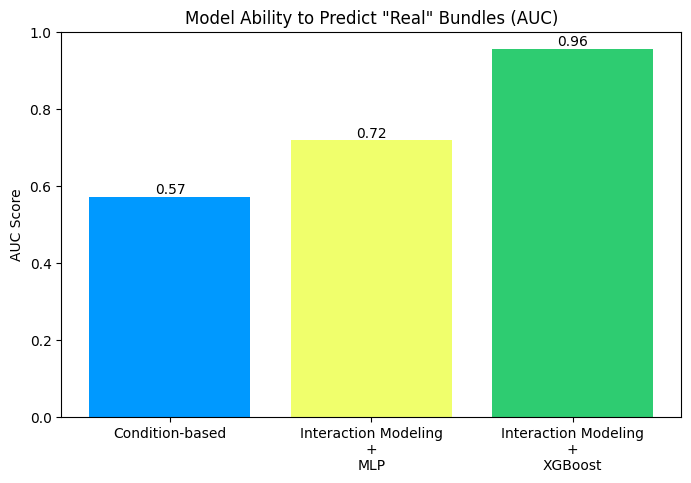

In [16]:
methods = ['Condition-based', 'Interaction Modeling\n+\nMLP', 'Interaction Modeling\n+\nXGBoost']
scores = [baseline1_auc, baseline2_auc, xgb_auc]

plt.figure(figsize=(8, 5))
bars = plt.bar(methods, scores, color=["#0099ff", "#f0ff6c", '#2ecc71'])
plt.title('Model Ability to Predict "Real" Bundles (AUC)')
plt.ylim(0.0, 1.0)
plt.ylabel('AUC Score')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}', ha='center', va='bottom')
plt.show()

### 2. What feature is importance in the current interaction modeling?

- **is_same_target:** is a feature tha explained who is the item worn by (Ladieswear, Menswear, Kid). Which make sense to have a big contribution since they are not interchangable, mens can not wear kid or women's cloth and vice versa.
- **price_diff:** this feature able to tells if the items are in the same tier or not
- **price_ratio:** is feature that can capture complementary (like accessory) attribute to the other bought item

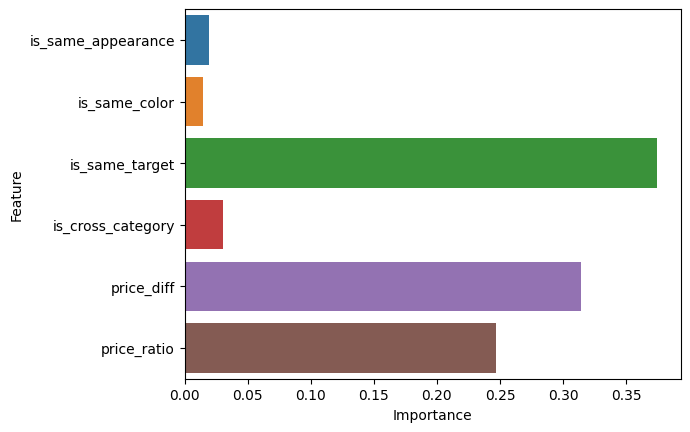

In [17]:
model_importance=pd.DataFrame(xgb_model.feature_importances_)
model_importance.columns=['Importance']
model_importance['Feature']= feature_cols
ax=sns.barplot(data=model_importance, x="Importance", y="Feature", hue="Feature")

### 3. How relevant are the generated bundles?

Here we check the results of generated bundle through the actual product image by selecting top 2 highest score relevant product based on XGboost model prediction

In [17]:
img_list = glob('data/images/*/*.jpg')
img_map = {os.path.basename(x).split('.')[0][1:]: x for x in img_list}

def get_item_img(item_id):
    return img_map.get(str(item_id), None)

def get_item_name(item_id):
    return product_df[product_df['article_id'] == item_id]['prod_name'].values[0]

def get_bundle_product(item_id, model, lookup_df):

    item_interactions = lookup_df[lookup_df.item_a == item_id]
    x_input = item_interactions[feature_cols]

    item_interactions['score'] = model.predict_proba(x_input)[:, 1] 
    item_list = item_interactions.sort_values('score', ascending=False).head(2).item_b.values

    return item_list


def visualize_multiple_bundles(target_items):
    n_rows = len(target_items)
    n_cols = 3
    
    # Create the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    
    if n_rows == 1:
        axes = [axes] 

    for row_idx, anchor_id in enumerate(target_items):
        # Get Recommendations for this specific anchor
        rec_items = get_bundle_product(anchor_id, xgb_model, test_df)
        items_to_plot = [anchor_id] + list(rec_items)
        
        # Labels for the columns
        labels = ["ANCHOR", "Bundle #1", "Bundle #2"]
        colors = ['blue', 'green', 'green']
        
        for col_idx in range(n_cols):
            ax = axes[row_idx][col_idx]
            
            if col_idx >= len(items_to_plot):
                ax.axis('off')
                continue
                
            item_id = items_to_plot[col_idx]
            
            # Get Metadata
            try:
                name = get_item_name(item_id)
                img_path = get_item_img(item_id)
            except:
                name = "Unknown"
                img_path = None
            
            display_name = (name[:25] + '..') if len(name) > 25 else name
            
            # Set Title
            ax.set_title(f"{labels[col_idx]}\n{display_name}", 
                         fontsize=10, fontweight='bold', color=colors[col_idx])
            
            # Show Image
            if img_path:
                try:
                    img = mpimg.imread(img_path)
                    ax.imshow(img)
                except FileNotFoundError:
                    ax.text(0.5, 0.5, 'Img Not Found', ha='center')
            else:
                ax.text(0.5, 0.5, 'No Path', ha='center')
            
            ax.axis('off')

    plt.tight_layout()
    plt.show()


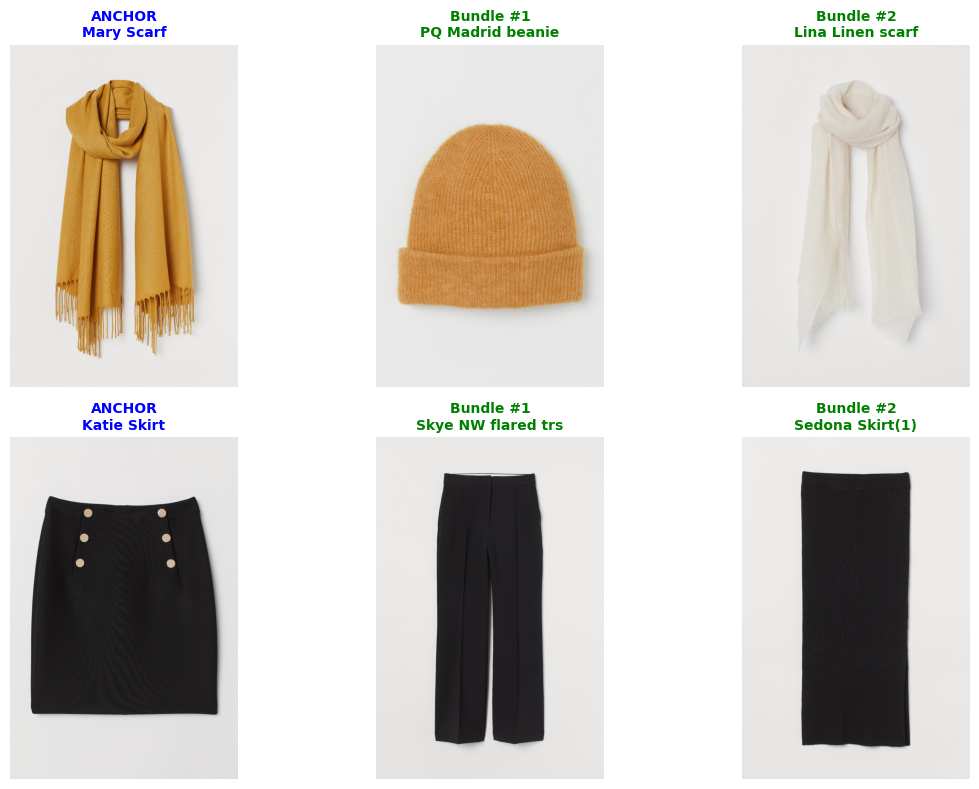

In [70]:
sample_items = test_df.item_a.sample(2).values
visualize_multiple_bundles(sample_items)

### 4. Can the bundle recommendation actually increase revenue or AOV?

In [ ]:
# TODO